# SCE Experiments

Goal:
- learn to use SCE data in python
- learn to use anndata objects, and ways to manipulate them
- compute dataset metrics for each of the datasets in python

Notes:
1) for 10x visium, filtered matrix_bc_h5
2) we can open the data already in scanpy

References:
- https://www.youtube.com/watch?v=cmOlCTGX4Ik
- https://www.youtube.com/watch?v=uvyG9yLuNSE

### Setup


In [2]:
import scanpy as sc
import scvi
import pandas as pd
import math
import numpy as np
# Plotting

import seaborn as sns

# System
from pathlib import Path
import os

# Ensure you are always in the parent dir
os.chdir('/home/kyan/git/cv-scdl3991/')
# data_path = Path('data/MH/MH_raw_counts.csv')
data_path = Path('data/')
dir_path = Path('MSC/osmfish.h5ad')
# Warnings 

import warnings
warnings.simplefilter("ignore")

/home/kyan/miniforge3/envs/cv-proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
os.listdir(data_path)

['MSC', 'HBCA1', 'DLPC', 'MH_raw_counts1.csv', 'MH']

In [39]:
def list_files_in_dir(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

In [50]:
list_files_in_dir(data_path)[:5]

['data/MH_raw_counts1.csv',
 'data/MSC/mRNA_coords_raw_counting.hdf5:Zone.Identifier',
 'data/MSC/osmfish.h5ad',
 'data/MSC/osmfish_remove_excluded.h5ad:Zone.Identifier',
 'data/MSC/MSC_gene_expression_FINAL.h5ad']

In [45]:
final_datas = [x for x in list_files_in_dir(data_path) if x.endswith("FINAL.h5ad")]

In [46]:
final_datas

['data/MSC/MSC_gene_expression_FINAL.h5ad']

### General Workflow

In [10]:
# !cat data/MH/MH_raw_counts1.csv | head

In [47]:
test_data = final_datas[0]
adata = sc.read_h5ad(test_data)

In [48]:
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [146]:
adata.uns["name"] = Path(final_datas[0]).parent.name.split('/')[-1]

In [49]:
adata.obs[:5] # metadata, e.g. cell barcodes

,ClusterName,ClusterID,Region
cell_778,Inhibitory_CP,18,Layer 6
cell_1409,Inhibitory_CP,18,Internal Capsule Caudoputamen
cell_3642,Inhibitory_CP,18,Layer 4
cell_1302,Inhibitory_CP,18,Internal Capsule Caudoputamen
cell_1285,Inhibitory_CP,18,Internal Capsule Caudoputamen


In [9]:
adata.var[:5] # variables, e.g. the genes

""
Gad2
Slc32a1
Crhbp
Cnr1
Vip


Is adata.X supposed to be 0,1 only? If I have values here, does it mean they were already log transformed?

In [11]:
adata.X, adata.X.shape # the matrix. 

(array([[ 268.4723  ,  867.64154 ,    0.      , ...,    0.      ,
          107.823784,  101.62062 ],
        [ 151.82317 ,  680.6384  ,   51.181667, ...,    0.      ,
          700.2619  ,  125.70961 ],
        [ 791.82306 , 1126.7451  ,  224.78687 , ...,    0.      ,
          117.16225 ,   36.807278],
        ...,
        [ 126.26297 ,    0.      ,    0.      , ...,  556.5547  ,
            0.      ,  929.2957  ],
        [  89.91866 ,    0.      ,    0.      , ...,    0.      ,
            0.      , 1191.2427  ],
        [  75.9398  ,    0.      ,    0.      , ...,    0.      ,
          266.8656  ,  838.37555 ]], dtype=float32),
 (4839, 33))

In [140]:
adata.X.sum(axis=1) # might have already been normalised to 5328

array([5327.9995, 5327.9995, 5328.    , ..., 5328.    , 5328.    ,
       5328.    ], dtype=float32)

## QC Metrics

Generate QC metrics for each dataset and add to the obs table.

In [58]:
# # extracting all the mouse mitochondrial genes, and saving it into a csv
# temp_mouse_df = pd.read_excel(data_path /"Mouse.MitoCarta3.0.xls" , sheet_name=1)
    
#  # Extract the third column (column number 2, as columns are 0-indexed)
# third_column = temp_mouse_df.iloc[:, 2]
# output_df = pd.DataFrame(third_column)
# output_df.to_csv("mouse_mt_genes", )

In [70]:
mouse_mt_genes = pd.read_csv(data_path / "mouse_mt_genes", index_col = 0)
mouse_mt_genes = mouse_mt_genes["Symbol"].to_list()
len(mouse_mt_genes)

1140

In [82]:
adata.var_names

Index(['Gad2', 'Slc32a1', 'Crhbp', 'Cnr1', 'Vip', 'Cpne5', 'Pthlh', 'Crh',
       'Tbr1', 'Lamp5', 'Rorb', 'Syt6', 'Kcnip2', 'Aldoc', 'Gfap', 'Serpinf1',
       'Mfge8', 'Sox10', 'Plp1', 'Pdgfra', 'Bmp4', 'Itpr2', 'Tmem2', 'Ctps',
       'Anln', 'Mrc1', 'Hexb', 'Ttr', 'Foxj1', 'Vtn', 'Flt1', 'Apln', 'Acta2'],
      dtype='object')

In [81]:
[x in mouse_mt_genes for x in adata.var_names]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

[1, 2, 4, 7]

In [174]:
def compute_qc_metrics(adata):
    
    # default is no filtering 
    # sc.pp.filter_cells(adata, min_genes = 200) 
    
    adata.var["mt"] = adata.var_names.str.startswith(("^(?i)MT-"))
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))


    # To calculate the % of counts assigned to the top x genes per cell. Some data have very small cell counts so % were used instead
    n_genes = len(adata.var)
    percents = [0.01, 0.05, 0.1, 0.2] # 1% , 5%, 10%, 20% of genes)
    ceiling_values = [math.ceil(n_genes * p) for p in percents]
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=ceiling_values, log1p=True)

    # Doing some renaming
    percent_names = [f"pct_counts_in_top_{n}_genes" for n in ceiling_values]
    new_names = [f"pct_counts_in_top_{round(n*100)}_pct_genes" for n in percents]
    adata.rename(dict(zip(percent_names, new_names)))
    # remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 
    #       'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb']
    
    # adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    #### Other Metrics #####
    adata.var['pct_highly_var_genes'] = adata.var["highly_variable"].sum() / len(adata.var)
    
    return adata

In [167]:
percent_names = [f"pct_counts_in_top_{n}_genes" for n in ceiling_values]
new_names = [f"pct_counts_in_top_{round(n*100)}_pct_genes" for n in percents]
print(dict(zip(percent_names, new_names)))

{'pct_counts_in_top_1_genes': 'pct_counts_in_top_1_pct_genes', 'pct_counts_in_top_2_genes': 'pct_counts_in_top_5_pct_genes', 'pct_counts_in_top_4_genes': 'pct_counts_in_top_10_pct_genes', 'pct_counts_in_top_7_genes': 'pct_counts_in_top_20_pct_genes'}


In [127]:
compute_qc_metrics(adata)

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', '_scvi_batch', '_scvi_labels', 'doublet', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_4_genes', 'pct_counts_in_top_7_genes'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'ClusterName_colors', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'

In [129]:
adata.var[:5]

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm
Gad2,False,False,False,4515,151.852249,5.029472,6.695598,734813.00000,13.507373,True,23.0,151.852519,45813.907012,0.857496
Slc32a1,False,False,False,2391,124.746445,4.834268,50.588965,603648.06250,13.310748,True,28.0,124.746550,73946.579551,0.749794
Crhbp,False,False,False,1676,100.057365,4.615688,65.364745,484177.59375,13.090209,True,16.0,100.057345,96882.573388,0.991510
Cnr1,False,False,False,3789,180.343826,5.200395,21.698698,872683.75000,13.679330,True,4.0,180.343607,59376.838508,1.389423
Vip,False,False,False,3981,162.183914,5.094878,17.730936,784807.93750,13.573195,True,13.0,162.184042,48396.231039,1.098261


In [130]:
adata.obs[:5]

,ClusterName,ClusterID,Region,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,...,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,_scvi_batch,_scvi_labels,doublet,pct_counts_in_top_1_genes,pct_counts_in_top_2_genes,pct_counts_in_top_4_genes,pct_counts_in_top_7_genes
cell_778,Inhibitory_CP,18,Layer 6,28,3.367296,5327.999512,8.580919,92.796962,0.0,0.0,...,0.0,0.0,0.0,0,0,False,16.284565,28.040978,45.822246,62.014791
cell_1409,Inhibitory_CP,18,Internal Capsule Caudoputamen,28,3.367296,5327.999512,8.580919,93.180375,0.0,0.0,...,0.0,0.0,0.0,0,0,False,13.143055,25.917801,42.124959,59.065557
cell_3642,Inhibitory_CP,18,Layer 4,29,3.401197,5328.000000,8.580919,94.365942,0.0,0.0,...,0.0,0.0,0.0,0,0,False,21.147619,37.572129,60.825142,71.873849
cell_1302,Inhibitory_CP,18,Internal Capsule Caudoputamen,20,3.044522,5328.000000,8.580919,99.999991,0.0,0.0,...,0.0,0.0,0.0,0,0,False,20.343375,31.091177,48.675834,67.030899
cell_1285,Inhibitory_CP,18,Internal Capsule Caudoputamen,26,3.295837,5328.000000,8.580919,94.269303,0.0,0.0,...,0.0,0.0,0.0,0,0,False,22.008201,31.131856,48.182483,62.016866


In [51]:
adata.var_names

Index(['Gad2', 'Slc32a1', 'Crhbp', 'Cnr1', 'Vip', 'Cpne5', 'Pthlh', 'Crh',
       'Tbr1', 'Lamp5', 'Rorb', 'Syt6', 'Kcnip2', 'Aldoc', 'Gfap', 'Serpinf1',
       'Mfge8', 'Sox10', 'Plp1', 'Pdgfra', 'Bmp4', 'Itpr2', 'Tmem2', 'Ctps',
       'Anln', 'Mrc1', 'Hexb', 'Ttr', 'Foxj1', 'Vtn', 'Flt1', 'Apln', 'Acta2'],
      dtype='object')

## Doublet Removal

In [92]:
 # annotate the highly variable genes (likely to be the most important ones)
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [93]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|█████████████████████████████████| 400/400 [02:09<00:00,  3.62it/s, v_num=1, train_loss_step=183, train_loss_epoch=158]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████████████████████████| 400/400 [02:09<00:00,  3.09it/s, v_num=1, train_loss_step=183, train_loss_epoch=158]


In [96]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 349/400:  87%|█████████████████████▊   | 349/400 [01:14<00:10,  4.67it/s, v_num=1, train_loss_step=1.67e-5, train_loss_epoch=3.23e-5]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.000. Signaling Trainer to stop.


In [98]:
solo.predict()

,doublet,singlet
cell_778,4.687270e-06,0.999995
cell_1409,1.104068e-06,0.999999
cell_3642,1.257894e-05,0.999987
cell_1302,4.942190e-06,0.999995
cell_1285,1.284665e-05,0.999987
...,...,...
cell_6462,3.328981e-07,1.000000
cell_260,1.229384e-05,0.999988
cell_4446,2.622331e-07,1.000000
cell_6431,2.563247e-07,1.000000


In [103]:
df = solo.predict()
df['predict'] = solo.predict(soft = False) # returns the actual probs instead of labels

In [105]:
df.groupby('predict').count() # appears to have no doublets

,doublet,singlet
predict,,
singlet,4839,4839


In [106]:
df['difference'] = df.doublet - df.singlet

<Axes: xlabel='difference', ylabel='Count'>

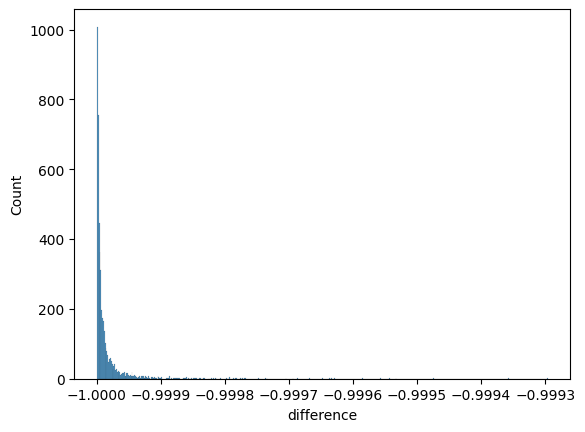

In [108]:
sns.histplot(df['difference']) # scale is very tiny, but can vary for multiple datasets

In [110]:
doublets = df[(df['predict'] == 'doublet') & (df['difference'] > 1)]
doublets

,doublet,singlet,predict,difference


In [112]:
adata.obs['doublet'] = adata.obs.index.isin(doublets)

In [136]:
adata.var.highly_variable.value_counts()

highly_variable
True    33
Name: count, dtype: int64

In [135]:
adata.var[:5]

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm
Gad2,False,False,False,4515,151.852249,5.029472,6.695598,734813.00000,13.507373,True,23.0,151.852519,45813.907012,0.857496
Slc32a1,False,False,False,2391,124.746445,4.834268,50.588965,603648.06250,13.310748,True,28.0,124.746550,73946.579551,0.749794
Crhbp,False,False,False,1676,100.057365,4.615688,65.364745,484177.59375,13.090209,True,16.0,100.057345,96882.573388,0.991510
Cnr1,False,False,False,3789,180.343826,5.200395,21.698698,872683.75000,13.679330,True,4.0,180.343607,59376.838508,1.389423
Vip,False,False,False,3981,162.183914,5.094878,17.730936,784807.93750,13.573195,True,13.0,162.184042,48396.231039,1.098261


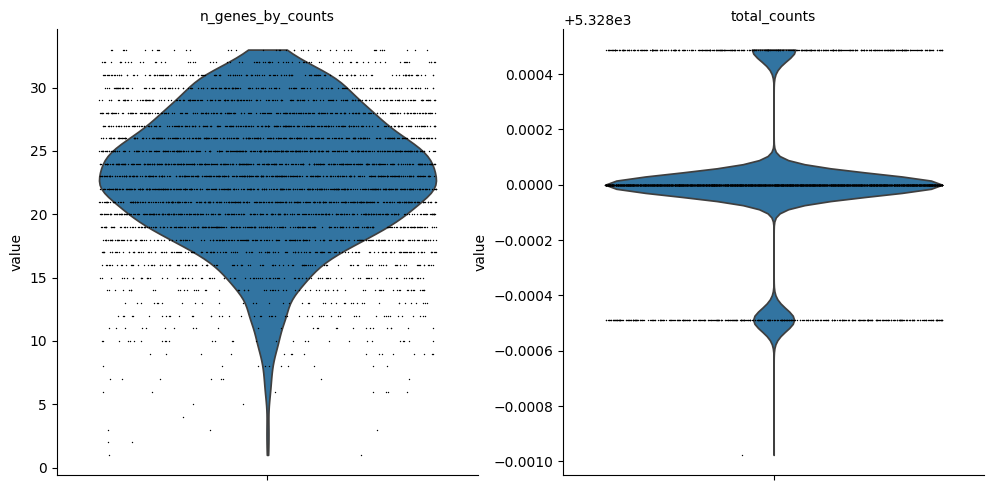

In [133]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts"],
            jitter=0.4,
            multi_panel=True)

# majority of cells have close to 30 genes, with some cells having less (cells with < x) genes are usually filtered out?

In [134]:
adata.var.dtypes

mt                          bool
ribo                        bool
hb                          bool
n_cells_by_counts          int64
mean_counts              float32
log1p_mean_counts        float32
pct_dropout_by_counts    float64
total_counts             float32
log1p_total_counts       float32
highly_variable             bool
highly_variable_rank     float32
means                    float64
variances                float64
variances_norm           float64
dtype: object

## Extracting Dataset Metrics:

In [ ]:
def extract_metrics(adata, agg=np.mean, exclude = None):
    """
    Extracts summary statistics from an AnnData object.
    
    Parameters:
    - adata: AnnData object, after highly variable genes, and doublets have been identified.
    - agg: function to apply to each variable (default: np.mean)
    
    Returns:
    - metrics: Dictionary containing summary statistics for each variable.
    """
    try:
        index = adata.uns['name']
    except:
        print("No name set for adata obj")

    ##### Computing metrics for all cells. #####

    # selecting only numeric quantities
    numeric_obs = adata.obs.select_dtypes(include=['number']).columns.tolist()
    numeric_obs = [item for item in numeric_obs if not item.startswith("_")]

    # applying our agg function
    obs_metrics = adata.obs[numeric_obs].apply(agg).to_list()

    ##### Computing metrics for all genes.#####
    
    # selecting only numeric quantities
    numeric_vars = adata.var.select_dtypes(include=['number']).columns.tolist()
    numeric_vars = [item for item in numeric_obs if not item.startswith("_")]

    # applying our agg function
    var_metrics = adata.obs[numeric_vars].apply(agg).to_list()
    
    ##### Custom defined metrics #####
    
    

We will fist extract all numeric columns, and then compute a summary statistic. Exclude the ones that start with a "_"

In [159]:
numeric_obs = adata.obs.select_dtypes(include=['number']).columns.tolist()
numeric_obs = [item for item in numeric_obs if not item.startswith("_")]
numeric_obs

['n_genes_by_counts',
 'log1p_n_genes_by_counts',
 'total_counts',
 'log1p_total_counts',
 'pct_counts_in_top_20_genes',
 'total_counts_mt',
 'log1p_total_counts_mt',
 'pct_counts_mt',
 'total_counts_ribo',
 'log1p_total_counts_ribo',
 'pct_counts_ribo',
 'total_counts_hb',
 'log1p_total_counts_hb',
 'pct_counts_hb',
 'pct_counts_in_top_1_genes',
 'pct_counts_in_top_2_genes',
 'pct_counts_in_top_4_genes',
 'pct_counts_in_top_7_genes']

In [158]:
adata.obs[numeric_obs].apply(np.median).to_list()

[23.0,
 3.1780538303479453,
 5328.0,
 8.58091926574707,
 98.30994935365052,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 20.125708136114632,
 33.299927426809816,
 51.22679862174186,
 68.54919112838425]

In [155]:
adata.var.dtypes

mt                          bool
ribo                        bool
hb                          bool
n_cells_by_counts          int64
mean_counts              float32
log1p_mean_counts        float32
pct_dropout_by_counts    float64
total_counts             float32
log1p_total_counts       float32
highly_variable             bool
highly_variable_rank     float32
means                    float64
variances                float64
variances_norm           float64
dtype: object

adata.var

## PCA

In [11]:
sc.pp.pca(adata)

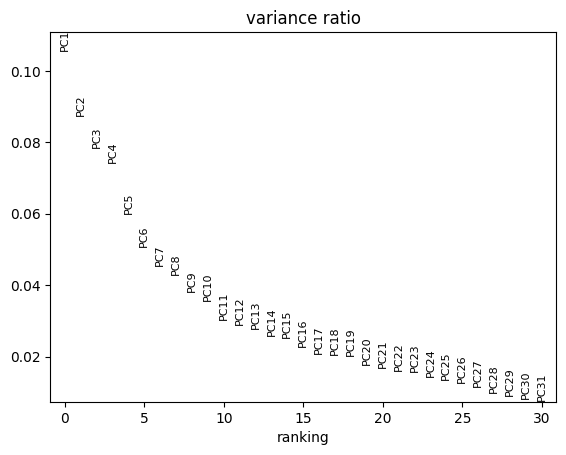

In [14]:
sc.pl.pca_variance_ratio(adata) # hard to capture all the data with just the firs 20 components

In [222]:
sc.pp.pca(adata, n_comps = 20)

In [13]:
adata.uns['pca'] # can append these as the last 20 columns

{'params': {'zero_center': True,
  'use_highly_variable': False,
  'mask_var': None},
 'variance': array([243011.12 , 201461.   , 180539.22 , 170862.88 , 138083.42 ,
        116935.13 , 104307.96 ,  98734.6  ,  87862.39 ,  82275.125,
         69750.555,  66273.92 ,  64205.207,  59550.26 ,  57851.332,
         52433.938,  47902.957,  47167.234,  46574.812,  40476.43 ,
         38713.266,  36567.004,  35889.117,  32667.43 ,  31205.771,
         29217.45 ,  26478.688,  22560.004,  20628.855,  18855.615,
         17780.34 ,  14688.594], dtype=float32),
 'variance_ratio': array([0.10558759, 0.08753418, 0.07844374, 0.0742394 , 0.05999682,
        0.05080796, 0.04532149, 0.04289988, 0.03817594, 0.03574829,
        0.0303064 , 0.02879582, 0.02789696, 0.02587441, 0.02513623,
        0.02278239, 0.02081369, 0.02049402, 0.02023661, 0.01758689,
        0.0168208 , 0.01588825, 0.01559371, 0.0141939 , 0.01355881,
        0.01269489, 0.01150491, 0.00980225, 0.00896317, 0.00819271,
        0.0077255 ,

# Final Pipeline

In [328]:
def setup_qc_metrics(adata):
    """
    Sets up and performs doublet detection for an AnnData object.

    1. Identifies the top 2000 highly variable genes using the 'seurat_v3' method 
    2. Uses the scVI model to detect and remove doublets
    3. Trains a SOLO model to further refine the detection of doublets.
   
    Parameters
    ----------
    adata : AnnData
        An AnnData object containing single-cell gene expression data.

    Returns
    -------
    AnnData
        The input AnnData object with additional QC metrics, including doublet predictions, stored in the `obs` DataFrame.
    """
    # setup

    adata.var_names_make_unique()

    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, flavor = 'seurat_v3', inplace=True)

    # using scvi to remove doublets
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()

    # training a solo model
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()

    temp_df = solo.predict()
    temp_df['predict'] = solo.predict(soft = False)
    temp_df['difference'] = temp_df.doublet - temp_df.singlet 
    doublets = temp_df[(temp_df['predict'] == 'doublet') & (temp_df['difference'] > 1)] # filtering out only those that have a predicted difference of more than 1

    # adding doublet prediction to adata object
    adata.obs['doublet'] = adata.obs.index.isin(doublets)

    return adata

In [333]:
def compute_qc_metrics(adata):
    """
    Compute quality control (QC) metrics for an AnnData object.

    This function calculates various QC metrics for the input AnnData object, such as the percentage of counts 
    assigned to specific gene categories (mitochondrial, ribosomal, hemoglobin genes), and the percentage of counts 
    assigned to the top x% of genes per cell. Additionally, it computes the percentage of highly variable genes.

    Parameters
    ----------
    adata : AnnData
        An AnnData object containing single-cell gene expression data. The input object should have a `var` DataFrame 
        with gene names.

    Returns
    -------
    AnnData
        The input AnnData object with additional QC metrics stored in the `obs` and `var` DataFrames.
    """
    
    # default is no filtering 
    # sc.pp.filter_cells(adata, min_genes = 200) 
    
    adata.var["mt"] = adata.var_names.str.startswith(("^(?i)MT-"))
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))


    # To calculate the % of counts assigned to the top x genes per cell. Some data have very small cell counts so % were used instead
    n_genes = len(adata.var)
    percents = [0.01, 0.05, 0.1, 0.2] # 1% , 5%, 10%, 20% of genes)
    ceiling_values = [math.ceil(n_genes * p) for p in percents]
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=ceiling_values, log1p=True)

    # Doing some renaming
    percent_names = [f"pct_counts_in_top_{n}_genes" for n in ceiling_values]
    new_names = [f"pct_counts_in_top_{round(n*100)}_pct_genes" for n in percents]
    adata.obs.rename(columns = dict(zip(percent_names, new_names)), inplace = True)
    # remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 
    #       'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb']
    
    # adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    #### Other Metrics #####
    adata.var['pct_highly_var_genes'] = adata.var["highly_variable"].sum() / len(adata.var)
    
    return adata

In [383]:
def extract_metrics(adata, agg=np.median, exclude = None):
    """
    Extracts summary statistics from an AnnData object.
    
    Parameters:
    - adata: AnnData object, after highly variable genes, and doublets have been identified.
    - agg: function to apply to each variable (default: np.mean)
    
    Returns:
    - dict, column_names: dictionary of {row: [metrics]}, list of all column_names
    """
    try:
        index = adata.uns['name']
    except:
        print("No name set for AnnData object")

    ##### Computing metrics for all cells. #####

    # selecting only numeric quantities
    numeric_obs = adata.obs.select_dtypes(include=['number']).columns.tolist()
    numeric_obs = [item for item in numeric_obs if not item.startswith("_")]

    # applying our agg function
    obs_metrics = adata.obs[numeric_obs].apply(agg).to_list()

    ##### Computing metrics for all genes.#####
    
    # selecting only numeric quantities
    numeric_vars = adata.var.select_dtypes(include=['number']).columns.tolist()
    numeric_vars = [item for item in numeric_vars if not item.startswith("_")]

    # applying our agg function
    var_metrics = adata.var[numeric_vars].apply(agg).to_list()

    ##### Custom defined metrics #####

    ## TODO

    ##### PCA Extraction #####

    obs_metrics.extend(var_metrics)
    numeric_obs.extend(numeric_vars)
    
    return {index: obs_metrics}, numeric_obs

## Proof of concept:

In [178]:
adata = sc.read_h5ad(test_data)

In [189]:
adata = setup_qc_metrics(adata) # takes around 2 minutes per dataset

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|█████████████████████████████████| 400/400 [02:12<00:00,  3.06it/s, v_num=1, train_loss_step=164, train_loss_epoch=159]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████████████████████████| 400/400 [02:12<00:00,  3.01it/s, v_num=1, train_loss_step=164, train_loss_epoch=159]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 177/400:  44%|███████████              | 177/400 [00:37<00:46,  4.77it/s, v_num=1, train_loss_step=0.00016, train_loss_epoch=4.55e-5]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.000. Signaling Trainer to stop.


In [201]:
adata = compute_qc_metrics(adata)

In [213]:
dataset_row, columns = extract_metrics(adata)

In [211]:
obs_metrics = [23.0, 3.1780538303479453, 5328.0, 8.58091926574707, 20.125708136114632, 33.299927426809816, 51.22679862174186, 68.54919112838425, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
var_metrics = [23.0, 3.1780538303479453, 5328.0, 8.58091926574707, 20.125708136114632, 33.299927426809816, 51.22679862174186, 68.54919112838425, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

obs_metrics.extend(var_metrics)

In [214]:
dataset_row, columns

({'MSC': [23.0,
   3.1780538303479453,
   5328.0,
   8.58091926574707,
   20.125708136114632,
   33.299927426809816,
   51.22679862174186,
   68.54919112838425,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   23.0,
   3.1780538303479453,
   5328.0,
   8.58091926574707,
   20.125708136114632,
   33.299927426809816,
   51.22679862174186,
   68.54919112838425,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]},
 ['n_genes_by_counts',
  'log1p_n_genes_by_counts',
  'total_counts',
  'log1p_total_counts',
  'pct_counts_in_top_1_genes',
  'pct_counts_in_top_2_genes',
  'pct_counts_in_top_4_genes',
  'pct_counts_in_top_7_genes',
  'total_counts_mt',
  'log1p_total_counts_mt',
  'pct_counts_mt',
  'total_counts_ribo',
  'log1p_total_counts_ribo',
  'pct_counts_ribo',
  'total_counts_hb',
  'log1p_total_counts_hb',
  'pct_counts_hb',
  'n_genes_by_counts',
  'log1p_n_genes_by_counts',
  'total_counts',
  'log1p_total_counts',
  'pct_counts_in_top

In [241]:
characteristics_df = pd.DataFrame.from_dict(dataset_row, columns = columns, orient='index') # 34 features so far

In [251]:
save_path = "outputs/characteristics/characteristics.csv"
characteristics_df.to_csv(save_path, index=True)

## Running for multiple datasets

### Loading in all the adata objects, and then running

Could also save results to a csv file

In [229]:
list_files_in_dir(data_path)[:5]

['data/mouse_mt_genes',
 'data/Mouse.MitoCarta3.0.xls',
 'data/MSC/mRNA_coords_raw_counting.hdf5:Zone.Identifier',
 'data/MSC/osmfish.h5ad',
 'data/MSC/osmfish_remove_excluded.h5ad:Zone.Identifier']

In [258]:
data_path_MSC = Path('data/MSC/MSC_gene_expression_FINAL.h5ad')
data_path_DPLC = Path('data/DLPC/151507')
data_path_HBCA1 = Path('data/HBCA1/')

In [326]:
adata = sc.read_h5ad(data_path_MSC)
adata1 = sc.read_visium(data_path_DPLC,
                       count_file = "151507_filtered_feature_bc_matrix.h5")
adata1.uns['name'] = 'DPLC_151707'
adata2 = sc.read_visium(data_path_HBCA1,
                       count_file = "V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5")
adata2.uns['name'] = 'HBCA1'

In [263]:
adata1, adata2

(AnnData object with n_obs × n_vars = 4226 × 33538
     obs: 'in_tissue', 'array_row', 'array_col'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial', 'name'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 3798 × 36601
     obs: 'in_tissue', 'array_row', 'array_col'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial', 'name'
     obsm: 'spatial')

In [374]:
adata1 = sc.read_visium(data_path_DPLC,
                       count_file = "151507_filtered_feature_bc_matrix.h5")
adata1 = setup_qc_metrics(adata1)
adata1 = compute_qc_metrics(adata1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|█████████████████████████| 400/400 [02:20<00:00,  2.70it/s, v_num=1, train_loss_step=4.21e+3, train_loss_epoch=4.06e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████████████████| 400/400 [02:20<00:00,  2.84it/s, v_num=1, train_loss_step=4.21e+3, train_loss_epoch=4.06e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 222/400:  56%|████████████████▋             | 222/400 [00:41<00:33,  5.35it/s, v_num=1, train_loss_step=0.0534, train_loss_epoch=0.2]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.205. Signaling Trainer to stop.


In [384]:
adata1.uns['name'] = 'DLPC_151507'
dataset_row, columns = extract_metrics(adata1)

In [385]:
dataset_row, columns

({'DLPC_151507': [1.0,
   34.0,
   66.0,
   1384.0,
   7.233455418621439,
   2463.5,
   7.809743881225586,
   56.48784498291701,
   100.0,
   100.0,
   100.0,
   0.0,
   0.0,
   0.0,
   176.0,
   5.176149845123291,
   7.092611312866211,
   1.0,
   0.6931471824645996,
   0.023001834750175476,
   nan,
   0.001419782300047326,
   0.0014181020843076252,
   0.9672428653744204,
   6.0,
   0.0014197822893038392,
   0.0014187752967700362,
   99.85802176999526,
   6.0,
   1.9459102153778076,
   0.05963384817222255]},
 ['in_tissue',
  'array_row',
  'array_col',
  'n_genes_by_counts',
  'log1p_n_genes_by_counts',
  'total_counts',
  'log1p_total_counts',
  'pct_counts_in_top_1_pct_genes',
  'pct_counts_in_top_5_pct_genes',
  'pct_counts_in_top_10_pct_genes',
  'pct_counts_in_top_20_pct_genes',
  'total_counts_mt',
  'log1p_total_counts_mt',
  'pct_counts_mt',
  'total_counts_ribo',
  'log1p_total_counts_ribo',
  'pct_counts_ribo',
  'total_counts_hb',
  'log1p_total_counts_hb',
  'pct_counts_hb'

In [361]:
adata2

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', '_scvi_batch', '_scvi_labels', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_336_genes', 'pct_counts_in_top_1677_genes', 'pct_counts_in_top_3354_genes', 'pct_counts_in_top_6708_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'

In [362]:
percent_names = [f"pct_counts_in_top_{n}_genes" for n in ceiling_values]
new_names = [f"pct_counts_in_top_{round(n*100)}_pct_genes" for n in percents]
adata2.obs.rename(columns = dict(zip(percent_names, new_names)), inplace = True)
    

In [364]:
adata2

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', '_scvi_batch', '_scvi_labels', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_1_pct_genes', 'pct_counts_in_top_5_pct_genes', 'pct_counts_in_top_10_pct_genes', 'pct_counts_in_top_20_pct_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'

In [372]:
adata2 = adata1

In [370]:
adata2 = compute_qc_metrics(adata2)

In [371]:
adata2

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', '_scvi_batch', '_scvi_labels', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_1_pct_genes', 'pct_counts_in_top_5_pct_genes', 'pct_counts_in_top_10_pct_genes', 'pct_counts_in_top_20_pct_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'pct_counts_in_top_1_pct_genes', 'pct_counts_in_top_5_pct_genes', 'pct_counts_in_top_10_pct_genes', 'pct_counts_in_top_20_pct_genes', 'pct_counts_in_top_1_pct_genes', 'pct_counts_in_top_5_pct_genes', 'pct_counts_in_top_10_pct_genes', 'pct_counts_in_top_20_pct_genes', 'pct_counts_in_top_1_pct_genes', 'pct_counts_in_top_5_pct_genes', 'pct_counts_in_top_10_pct_genes', 'pct_counts_in_top_20_pct_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'h

In [334]:
adata1 = compute_qc_metrics(adata1)

In [340]:
adata1.obs.columns

Index(['in_tissue', 'array_row', 'array_col', '_scvi_batch', '_scvi_labels',
       'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_1_pct_genes',
       'pct_counts_in_top_5_pct_genes', 'pct_counts_in_top_10_pct_genes',
       'pct_counts_in_top_20_pct_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb',
       'pct_counts_in_top_1_pct_genes', 'pct_counts_in_top_5_pct_genes',
       'pct_counts_in_top_10_pct_genes', 'pct_counts_in_top_20_pct_genes',
       'pct_counts_in_top_1_pct_genes', 'pct_counts_in_top_5_pct_genes',
       'pct_counts_in_top_10_pct_genes', 'pct_counts_in_top_20_pct_genes'],
      dtype='object')

In [336]:
adata1.obs

,in_tissue,array_row,array_col,_scvi_batch,_scvi_labels,doublet,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,...,log1p_total_counts_hb,pct_counts_hb,pct_counts_in_top_1_pct_genes,pct_counts_in_top_5_pct_genes,pct_counts_in_top_10_pct_genes,pct_counts_in_top_20_pct_genes,pct_counts_in_top_1_pct_genes,pct_counts_in_top_5_pct_genes,pct_counts_in_top_10_pct_genes,pct_counts_in_top_20_pct_genes
AAACAACGAATAGTTC-1,1,0,16,0,0,False,727,6.590301,948.0,6.855409,...,1.098612,0.210970,58.755274,100.000000,100.0,100.0,58.755274,100.000000,100.0,100.0
AAACAAGTATCTCCCA-1,1,50,102,0,0,False,2170,7.682943,4261.0,8.357493,...,0.693147,0.023469,49.119925,88.429946,100.0,100.0,49.119925,88.429946,100.0,100.0
AAACAATCTACTAGCA-1,1,3,43,0,0,False,1093,6.997596,1969.0,7.585789,...,0.000000,0.000000,61.554088,100.000000,100.0,100.0,61.554088,100.000000,100.0,100.0
AAACACCAATAACTGC-1,1,59,19,0,0,False,1896,7.548029,3368.0,8.122372,...,0.000000,0.000000,48.752969,93.497625,100.0,100.0,48.752969,93.497625,100.0,100.0
AAACAGCTTTCAGAAG-1,1,43,9,0,0,False,1620,7.390799,2981.0,8.000349,...,0.000000,0.000000,53.237169,100.000000,100.0,100.0,53.237169,100.000000,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,0,0,False,1320,7.186144,2337.0,7.757051,...,0.693147,0.042790,57.894737,100.000000,100.0,100.0,57.894737,100.000000,100.0,100.0
TTGTTTCACATCCAGG-1,1,58,42,0,0,False,1444,7.275865,2331.0,7.754482,...,1.609438,0.171600,52.338052,100.000000,100.0,100.0,52.338052,100.000000,100.0,100.0
TTGTTTCATTAGTCTA-1,1,60,30,0,0,False,629,6.445720,819.0,6.709304,...,2.708050,1.709402,64.224664,100.000000,100.0,100.0,64.224664,100.000000,100.0,100.0
TTGTTTCCATACAACT-1,1,45,27,0,0,False,1697,7.437206,3092.0,8.036897,...,0.693147,0.032342,51.455369,99.353169,100.0,100.0,51.455369,99.353169,100.0,100.0


In [310]:
n_genes = adata1.n_vars
percents = [0.01, 0.05, 0.1, 0.2] # 1% , 5%, 10%, 20% of genes)
ceiling_values = [math.ceil(n_genes * p) for p in percents]


percent_names = [f"pct_counts_in_top_{n}_genes" for n in ceiling_values]
new_names = [f"pct_counts_in_top_{round(n*100)}_pct_genes" for n in percents]

In [275]:
dataset_row, columns

({'DPLC_151707': [1.0,
   34.0,
   66.0,
   1384.0,
   7.233455418621439,
   2463.5,
   7.809743881225586,
   56.48784498291701,
   100.0,
   100.0,
   100.0,
   0.0,
   0.0,
   0.0,
   176.0,
   5.176149845123291,
   7.092611312866211,
   1.0,
   0.6931471824645996,
   0.023001834750175476,
   1.0,
   34.0,
   66.0,
   1384.0,
   7.233455418621439,
   2463.5,
   7.809743881225586,
   56.48784498291701,
   100.0,
   100.0,
   100.0,
   0.0,
   0.0,
   0.0,
   176.0,
   5.176149845123291,
   7.092611312866211,
   1.0,
   0.6931471824645996,
   0.023001834750175476]},
 ['in_tissue',
  'array_row',
  'array_col',
  'n_genes_by_counts',
  'log1p_n_genes_by_counts',
  'total_counts',
  'log1p_total_counts',
  'pct_counts_in_top_336_genes',
  'pct_counts_in_top_1677_genes',
  'pct_counts_in_top_3354_genes',
  'pct_counts_in_top_6708_genes',
  'total_counts_mt',
  'log1p_total_counts_mt',
  'pct_counts_mt',
  'total_counts_ribo',
  'log1p_total_counts_ribo',
  'pct_counts_ribo',
  'total_coun

In [352]:
adata1.obs.columns

Index(['in_tissue', 'array_row', 'array_col', '_scvi_batch', '_scvi_labels',
       'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_1_pct_genes',
       'pct_counts_in_top_5_pct_genes', 'pct_counts_in_top_10_pct_genes',
       'pct_counts_in_top_20_pct_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb',
       'pct_counts_in_top_1_pct_genes', 'pct_counts_in_top_5_pct_genes',
       'pct_counts_in_top_10_pct_genes', 'pct_counts_in_top_20_pct_genes',
       'pct_counts_in_top_1_pct_genes', 'pct_counts_in_top_5_pct_genes',
       'pct_counts_in_top_10_pct_genes', 'pct_counts_in_top_20_pct_genes'],
      dtype='object')

In [349]:
dataset_row, columns = extract_metrics(adata1)

In [350]:
len(columns), len(dataset_row['DPLC_151707'])

(56, 104)

In [ ]:
new_df = pd.DataFrame.from_dict(dataset_row, columns = columns, 
                                    orient='index') 


In [ ]:
def run_all_qc(adata):
    save_path = "outputs/characteristics/characteristics.csv"
    
    adata = setup_qc_metrics(adata)
    adata = compute_qc_metrics(adata)
    dataset_row, columns = extract_metrics(adata)

    saved_df = pd.read_csv(save_path, index_col = 0)
    new_df = pd.DataFrame.from_dict(dataset_row, columns = columns, 
                                    orient='index') 
    assert saved_df.columns == new_df.columns

    pd.concat[saved_

    

In [344]:

new_df.loc[:, ~new_df.columns.duplicated(keep='last')]

ValueError: 56 columns passed, passed data had 104 columns

In [337]:
old_df = pd.read_csv(save_path, index_col = 0)

In [338]:
merged_df = pd.merge(old_df, new_df)

MergeError: Data columns not unique: Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt',
       'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo',
       'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb',
       'pct_counts_hb'],
      dtype='object')

In [3]:

data_path_MSC = Path('data/MSC/MSC_gene_expression_FINAL.h5ad')
data_path_DPLC_1 = Path('data/DLPC/151507')
data_path_DPLC_2 = Path('data/DLPC/151508')
data_path_DPLC_3 = Path('data/DLPC/151509')
data_path_HBCA1 = Path('data/HBCA1/')

adata = sc.read_h5ad(data_path_MSC)
adata.uns['name'] = 'MSC'


adata1 = sc.read_visium(data_path_DPLC_1,
                       count_file = "151507_filtered_feature_bc_matrix.h5")
adata1.uns['name'] = 'DPLC_151707'

adata2 = sc.read_visium(data_path_DPLC_2,
                       count_file = "151508_filtered_feature_bc_matrix.h5")
adata2.uns['name'] = 'DPLC_151708'


adata3 = sc.read_visium(data_path_DPLC_3,
                       count_file = "151509_filtered_feature_bc_matrix.h5")
adata3.uns['name'] = 'DPLC_151709'


adata4 = sc.read_visium(data_path_HBCA1,
                       count_file = "V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5")
adata4.uns['name'] = 'HBCA1'